# Correlates of evasion

## Guessing which countries might be linked to the Panama Papers

In this part, we try to determine whether the current country evaluation systems on financial crimes used by regulators are good predictors of the amount dealings which a country has with Mossack Fonseca.

## Methodology

The correlates of evasion are identified by performing linear regressions for each financial indicator while controlling for GDP and Population. We apply logarithm to the number of links, GDP and population, and we standardized all indicators except for INCSR Primary Concern and FATF greylist, which hold binary values. To make it simple, each regression has the form: log(Number of entities) = a (standardized Indicator of Interest) + b log(Population) + c log(GDP) + E with E ~ N(0, σ^2). Computations are carried in the python library statsmodels.

## Data sources:

Corruption Perception Index: https://www.transparency.org/news/feature/corruption_perceptions_index_2016?gclid=Cj0KCQiAoo7gBRDuARIsANeJKUYknSqOUd8I-hylRkeaqD9ODYA2Pj3Nwdc1Zt1F_oYdyIdwWlp_0CoaAr-uEALw_wcB

Gini index: https://data.worldbank.org/indicator/SI.POV.GINI

FATF greylist (High-risk countries): http://www.fatf-gafi.org/countries/#high-risk

Cumulative illicit flows: https://datawrapper.dwcdn.net/BXVXP/1/

Financial Secrecy Index Rankings: https://www.financialsecrecyindex.com/Archive2015/index.php?id=3

Financial Transparency and Standards score: https://index.baselgovernance.org/

Population: https://data.worldbank.org/indicator/SP.POP.TOTL

Average Income: https://data.worldbank.org/indicator/NY.ADJ.NNTY.PC.CD




In [1]:
#Import useful libraries
import pandas as pd
import numpy as np
import scipy.stats as st
import warnings
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.api as sm
import math

warnings.simplefilter('ignore')
PATH='./data'

# Loading data

Here, we load all the data necessary for our regression model. The first set of data loaded is from ICIJ release of Mossack Fonseca's accounts information, and the second set of data are the different country indicators (Average income, Financial Secrecy, FATF greylist, etc.) used for our regression model.

In [2]:
#Loading Panama papers data
#Load each csv file into a dataframe
address = pd.read_csv(PATH+'/address.csv')
edges = pd.read_csv(PATH+'/edges.csv')
entity = pd.read_csv(PATH+'/entity.csv')
intermediary = pd.read_csv(PATH+'/intermediary.csv')
officer = pd.read_csv(PATH+'/officer.csv')

In [3]:
#load indicator data
AI=pd.read_excel(PATH+'/Average-income.xls')
Pop=pd.read_excel(PATH+'/population.xls')
INCSR=pd.read_excel(PATH+'/INCSR-2016.xlsx')
FATF_greylist=pd.read_excel(PATH+'/FATF-greylist.xlsx')
FSI=pd.read_excel(PATH+'/FSI-Rankings-2015.xlsx')
CPI=pd.read_excel(PATH+'/Corruption-Perceptions-Index.xlsx')
CIF=pd.read_csv(PATH+'/Cumulative-illicit-flows.csv')
FTS=pd.read_excel(PATH+'/FTS-Score-2018.xls')
IGI=pd.read_excel(PATH+'/Income-Gini-Index.xlsx')

# Cleaning data

We need to clean thoroughly these indicator data, since they all come from different sources. We cleaned the datasets as best as we can and know how. We had to make a compromise between very clean datasets and having enough entries, because the size of those data is limited by the number of countries on this planet. Therefore, we refrained from dropping the NaN values until the the part where we actually make the regression.

## Cleaning Panama Papers countries data

This step was done for milestone 2, so the following is just a copy paste of what we did earlier

In [4]:
#Drop useless columns
address.drop(['name', 'sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
edges.drop(['sourceID', 'valid_until'], axis=1, inplace=True)
officer.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
intermediary.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
entity.drop(['closed_date', 'company_type', 'service_provider', 'sourceID', 'valid_until', 'note', 'country_codes', 'jurisdiction'], axis=1, inplace=True)

In [5]:
#Convert dates to datetime
entity['incorporation_date'] = pd.to_datetime(entity['incorporation_date'], format='%d-%b-%Y')
entity['inactivation_date'] = pd.to_datetime(entity['inactivation_date'], format='%d-%b-%Y')
entity['struck_off_date'] = pd.to_datetime(entity['struck_off_date'], format='%d-%b-%Y', errors='coerce')

In [6]:
#Plot value counts
def plot_counts(title, data):
    plt.figure(figsize=(8,4))
    data.plot(kind='bar')
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=85)
    plt.plot()

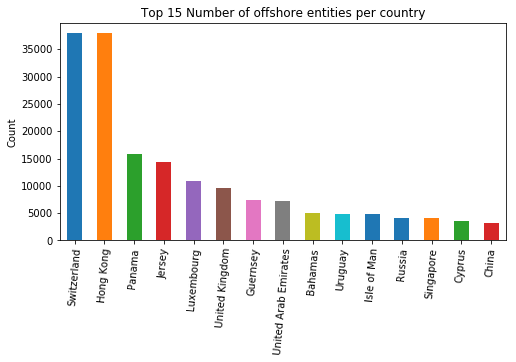

In [7]:
countries = entity['countries'].value_counts()
plot_counts("Top 15 Number of offshore entities per country", countries[:15])

In [8]:
#Store the countries count for later use
panama_counts=pd.DataFrame(countries).reset_index()
panama_counts.columns=['countries', 'panama_papers count']
panama_counts.head()

,countries,panama_papers count
0,Switzerland,37911
1,Hong Kong,37911
2,Panama,15811
3,Jersey,14331
4,Luxembourg,10840


## Cleaning Indicator data

We will look at all the indicator data (mostly from .xls files) and make them easier to read and compare.

In [9]:
#Average income
print('AI',AI.shape[0],'entries')
AI.head()

AI 267 entries


,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61
0,Last Updated Date,2018-11-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2008.000000,2009.000000,2010.000000,2011.000000,2012.000000,2013.00000,2014.000000,2015.00000,2016.000000,2017.0
3,Aruba,ABW,Adjusted net national income per capita (curre...,NY.ADJ.NNTY.PC.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,Adjusted net national income per capita (curre...,NY.ADJ.NNTY.PC.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,331.233394,395.574537,486.988112,535.340277,590.467493,559.23394,548.537095,494.30163,489.784741,NaN


In [10]:
#Attempt in creating a dictionary for some similar dataframes in order to have matching country names, until we realized that...
#...it would be too time consuming and inefficient to correspond all variations of naming format. We didn't throw away what's done.
countries_dict={"Hong Kong SAR, China": "Hong Kong",
               "Bahamas, The":"Bahamas",
               "Russian Federation":"Russia"}

In [11]:
#Only keep useful columns and reorganize them in a readable way
AI=AI[['Data Source', 'Unnamed: 60']].dropna()
AI.columns=['countries', 'Average Income']
AI=AI.drop([2])
AI['countries']=AI['countries'].replace(countries_dict)
AI.head()

,countries,Average Income
4,Afghanistan,489.784741
5,Angola,1777.448410
6,Albania,3606.903851
8,Arab World,5182.501036
9,United Arab Emirates,34579.669587


In [12]:
#Population size
print('Pop',Pop.shape[0],'entries')
Pop.head()

Pop 267 entries


,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61
0,Last Updated Date,2018-11-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
4,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0


In [13]:
#Only keep useful columns and reorganize them in a readable way
Pop=Pop[['Data Source', 'Unnamed: 60']].dropna()
Pop.columns=['countries', 'Population']
Pop=Pop.drop([2])
Pop['countries']=Pop['countries'].replace(countries_dict)
Pop.head()

,countries,Population
3,Aruba,104822.0
4,Afghanistan,34656032.0
5,Angola,28813463.0
6,Albania,2876101.0
7,Andorra,77281.0


In [14]:
#INCSR Primary Concern
print('INCSR',INCSR.shape[0],'entries')
INCSR.head()

INCSR 75 entries


,Primary Concern,Concern,Others Monitored,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Afghanistan,Albania,Andorra,NaN,NaN,NaN,NaN
1,Antigua and Barbuda,Algeria,Anguilla,NaN,NaN,NaN,NaN
2,Argentina,Angola,Armenia,NaN,NaN,NaN,NaN
3,Australia,Aruba,Bermuda,NaN,NaN,NaN,NaN
4,Austria,Azerbaijan,Botswana,NaN,NaN,NaN,NaN


In [15]:
#Only keep useful columns and reorganize them in a readable way
INCSR['Primary_Concern']='Yes'
INCSR=INCSR[['Primary Concern','Primary_Concern']].dropna()
INCSR.columns=['countries', 'Primary Concern']
INCSR.head()

,countries,Primary Concern
0,Afghanistan,Yes
1,Antigua and Barbuda,Yes
2,Argentina,Yes
3,Australia,Yes
4,Austria,Yes


In [16]:
#FATF greylist
print('FATF_greylist',FATF_greylist.shape[0],'entries')
FATF_greylist.head(5)

FATF_greylist 13 entries


,FATF greylist
0,Bahamas
1,Botswana
2,Democratic People's Republic of Korea
3,Ethiopia
4,Ghana


In [17]:
#Just need to rename the columns
FATF_greylist['greylist']='Yes'
FATF_greylist.columns=['countries', 'greylist']
FATF_greylist.head()

,countries,greylist
0,Bahamas,Yes
1,Botswana,Yes
2,Democratic People's Republic of Korea,Yes
3,Ethiopia,Yes
4,Ghana,Yes


In [18]:
#Financial Secrecy Index
print('FSI',FSI.shape[0],'entries')
FSI.head()

FSI 103 entries


,FSI 2015 - FINAL RESULTS,Unnamed: 1,Unnamed: 2,Unnamed: 3
RANK,Jurisdiction,FSI Value,Secrecy Score,Global Scale Weight
1,Switzerland,1466.13,72.6,5.62458
2,Hong Kong,1259.42,72,3.84165
3,USA,1254.76,60,19.6027
4,Singapore,1147.12,68.96,4.2801


In [19]:
#Upon inspecting the data, we need to remove some unusable values and rename the columns
FSI.columns=['countries', 'FSI Value', 'Secrecy Score', 'Global Scale Weight']
FSI=FSI.drop('RANK').reset_index(drop=True)
FSI=FSI[FSI['FSI Value']!='-']
FSI.index.name='Rank'
FSI.head()

,countries,FSI Value,Secrecy Score,Global Scale Weight
Rank,,,,
0,Switzerland,1466.13,72.6,5.62458
1,Hong Kong,1259.42,72,3.84165
2,USA,1254.76,60,19.6027
3,Singapore,1147.12,68.96,4.2801
4,Cayman Islands,1013.16,65.24,4.85743


In [20]:
#Corruption Perceptions Index
print('CPI',CPI.shape[0],'entries')
CPI.head()

CPI 176 entries


,Country,CPI2016,Rank,Region,WB Code,World Bank CPIA,World Economic Forum EOS,Global Insight Country Risk Ratings,Bertelsmann Foundation Transformation Index,African Development Bank CPIA,...,Lower CI,Upper CI,Min,Max,OECD,G20,BRICS,EU,Arab states,Unnamed: 32
0,New Zealand,90,1,AP,NZL,NaN,90.0,83,NaN,NaN,...,86,94,79,99,y,NaN,NaN,NaN,NaN,NaN
1,Denmark,90,1,WE/EU,DNK,NaN,85.0,83,NaN,NaN,...,86,94,83,99,y,NaN,NaN,y,NaN,NaN
2,Finland,89,3,WE/EU,FIN,NaN,91.0,83,NaN,NaN,...,87,92,83,94,y,NaN,NaN,y,NaN,NaN
3,Sweden,88,4,WE/EU,SWE,NaN,86.0,83,NaN,NaN,...,85,90,83,93,y,NaN,NaN,y,NaN,NaN
4,Switzerland,86,5,WE/EU,CHE,NaN,80.0,83,NaN,NaN,...,83,89,80,90,y,NaN,NaN,NaN,NaN,NaN


In [21]:
#Only keep useful columns and reorganize them in a readable way
CPI=pd.DataFrame(CPI[['Country', 'CPI2016', 'Rank']])
CPI.columns=['countries', 'CPI Score', 'Rank']
CPI.head()

,countries,CPI Score,Rank
0,New Zealand,90,1
1,Denmark,90,1
2,Finland,89,3
3,Sweden,88,4
4,Switzerland,86,5


In [22]:
#Cumulative illicit flows in developping countries, the data is already clean, we only needed to change a title
print('CIF',CIF.shape[0],'entries')
CIF=CIF.rename(columns={'Country':'countries'})
CIF.head()

CIF 149 entries


,countries,billions of U.S. dollars
0,Afghanistan,1.33
1,Albania,1.23
2,Algeria,15.25
3,Angola,3.85
4,Antigua and Barbuda,0.05


In [23]:
#Financial Transparency and Standard
print('FTS',FTS.shape[0],'entries')
FTS.head()

FTS 151 entries


,Basel AML Index 2017 Public version,Unnamed: 1,Unnamed: 2
0,0=Low Risk 10=High Risk,NaN,NaN
1,Country,Overall score 2017,Ranking 2017
2,Iran,8.60239,1
3,Afghanistan,8.38169,2
4,Guinea-Bissau,8.34944,3


In [24]:
#Rename columns and remove '*' from country names
FTS.columns=['countries', 'FTS score', 'Ranking']
FTS=FTS.drop([0,1]).dropna()
FTS['countries']= FTS['countries'].map(lambda r: r.rstrip('*'))
FTS.head()

,countries,FTS score,Ranking
2,Iran,8.60239,1
3,Afghanistan,8.38169,2
4,Guinea-Bissau,8.34944,3
5,Tajikistan,8.28399,4
6,Laos,8.27996,5


In [25]:
#Income Gini Index
print('IGI',IGI.shape[0],'entries')
IGI.head()

IGI 157 entries


,Rank,countries,Gini coefficient
0,1,Lesotho,63.2
1,2,South Africa,62.5
2,3,"Micronesia, Federated States of",61.1
3,4,Haiti,60.8
4,5,Botswana,60.5


In [26]:
#just removing unavailable values
IGI=IGI.drop('Rank',axis=1).dropna()
IGI.head()

,countries,Gini coefficient
0,Lesotho,63.2
1,South Africa,62.5
2,"Micronesia, Federated States of",61.1
3,Haiti,60.8
4,Botswana,60.5


# Looking for linear dependency and predicatability of indicator variables

Now that we have cleaned our data, it is time to put them to use and see what kind of relationships we can discover.

## First things first: regroup the data

In order to work in a more organized way, we regroup the different datasets by joining together on country name and using as standard the country naming format used by ICIJ in the Panama Papers data.

In [27]:
#Time to merge
all_df=[panama_counts, AI, Pop, INCSR, FATF_greylist, FSI, CPI, CIF, FTS, IGI]
merged_df=reduce(lambda left,right: pd.merge(left, right , on='countries', how='left'),all_df)
merged_df.head()

,countries,panama_papers count,Average Income,Population,Primary Concern,greylist,FSI Value,Secrecy Score,Global Scale Weight,CPI Score,Rank,billions of U.S. dollars,FTS score,Ranking,Gini coefficient
0,Switzerland,37911,63377.625946,8373338.0,Yes,NaN,1466.13,72.6,5.62458,86.0,5.0,NaN,5.14523,102,29.5
1,Hong Kong,37911,NaN,7336600.0,Yes,NaN,1259.42,72,3.84165,77.0,15.0,NaN,NaN,NaN,53.9
2,Panama,15811,11446.631588,4034119.0,Yes,NaN,415.663,72.36,0.13205,38.0,87.0,21.04,7.01111,30,50.7
3,Jersey,14331,NaN,NaN,Yes,NaN,354.04,64.93,0.216346,NaN,NaN,NaN,NaN,NaN,0.3
4,Luxembourg,10840,56303.489596,582014.0,Yes,NaN,816.99,55.11,11.6299,81.0,10.0,NaN,5.40283,96,30.4


In [28]:
#Drop useless column, so that we keep only one value for each indicator variable
merged_df=merged_df.drop(['FSI Value', 'Global Scale Weight','Rank','Ranking'], axis=1)
merged_df.head()

,countries,panama_papers count,Average Income,Population,Primary Concern,greylist,Secrecy Score,CPI Score,billions of U.S. dollars,FTS score,Gini coefficient
0,Switzerland,37911,63377.625946,8373338.0,Yes,NaN,72.6,86.0,NaN,5.14523,29.5
1,Hong Kong,37911,NaN,7336600.0,Yes,NaN,72,77.0,NaN,NaN,53.9
2,Panama,15811,11446.631588,4034119.0,Yes,NaN,72.36,38.0,21.04,7.01111,50.7
3,Jersey,14331,NaN,NaN,Yes,NaN,64.93,NaN,NaN,NaN,0.3
4,Luxembourg,10840,56303.489596,582014.0,Yes,NaN,55.11,81.0,NaN,5.40283,30.4


In [29]:
#We basically write No instead of NaN in a Yes/No data, and then transform the Yes/No into binary values (1/0)
Default={"panama_papers count":0,
         "Primary Concern":'No',
         "greylist":'No'}
merged_df=merged_df.fillna(Default)

To_numbers={'Yes':1,
           'No':0}
merged_df=merged_df.replace(To_numbers).set_index('countries')
merged_df.head()

,panama_papers count,Average Income,Population,Primary Concern,greylist,Secrecy Score,CPI Score,billions of U.S. dollars,FTS score,Gini coefficient
countries,,,,,,,,,,
Switzerland,37911,63377.625946,8373338.0,1,0,72.60,86.0,NaN,5.145227,29.5
Hong Kong,37911,NaN,7336600.0,1,0,72.00,77.0,NaN,NaN,53.9
Panama,15811,11446.631588,4034119.0,1,0,72.36,38.0,21.04,7.011108,50.7
Jersey,14331,NaN,NaN,1,0,64.93,NaN,NaN,NaN,0.3
Luxembourg,10840,56303.489596,582014.0,1,0,55.11,81.0,NaN,5.402829,30.4


## Linear regression

With the data above, we can proceed to linear regression using statsmodels (We chose this method over Scikit because we wanted to retrieve the p-values for our regression models).

In [30]:
#Renaming the columns and identifying feature variables, value to predict, and control variables
merged_df.columns=['PP count', 'Average Income', 'Population', 'INCSR Primary Concern', 'FATF greylist', 'FSI Score', 'CPI Score', 'CIF Score', 'FTS Score', 'Income Gini Index']
features=['INCSR Primary Concern', 'FATF greylist', 'FSI Score', 'CPI Score', 'CIF Score', 'FTS Score', 'Income Gini Index']
to_pred=['PP count']
control=['Average Income', 'Population']

In [31]:
#We apply logarithm or standardization to some of the indicator variables
feat_std=['FSI Score', 'CPI Score', 'CIF Score', 'FTS Score', 'Income Gini Index']
feat_same=['INCSR Primary Concern', 'FATF greylist']

Because of the large amount of NaN values in some of the collected data (for instance, the CIF is only available for developing countries), we have decided to not use the method dropna() as we would lose too many precious data. Therefore, we created the function below which selects each feature separately, and use all the data available for this feature only.

In [51]:
#Function specific to our dataframe, which computes the linear coefficient for each indicator variable taken separately along...
#...with the two control variables (log(Average income) and log(Population size)), in order to predict log(#accounts linked)

def Linear_coefficient_sm(df,features,to_do=None):
    a=[]
    b=[]
    c=[]
    for feat in features:
        temp=df[['PP count', 'Average Income', 'Population', feat]]
        temp=temp.dropna()
        temp['Average Income']=np.log(temp['Average Income'])
        temp['Population']=np.log(temp['Population'])
        temp['PP count']=np.log(temp['PP count'])
        if to_do == 'std':
            standardize = lambda x: (x-x.mean()) / x.std()
            temp[feat]=standardize(temp[feat])
        X=temp[['Average Income', 'Population', feat]]
        y=temp['PP count']
        X2=sm.add_constant(X)
        est=sm.OLS(y,X2)
        est2=est.fit()
        a.append(est2.params[3])
        b.append(est2.pvalues[3])
        c.append(est2.rsquared)
    return a,b,c

In [52]:
#Apply above function to retrieve linear regression coefficients, p_values and r_squared data
coef_std, p_values_std, r_squared_std= Linear_coefficient_sm(merged_df,feat_std,to_do='std')
coef_same, p_values_same, r_squared_same= Linear_coefficient_sm(merged_df,feat_same,to_do=None)

In [54]:
#Regroup coefficients, p_values and R-squared values in a list
coef=np.concatenate((coef_same, coef_std))
p_value=np.concatenate((p_values_same, p_values_std))
r_squared=np.concatenate((r_squared_same, r_squared_std))

In [55]:
#Create dataframe
combined={'Linear coefficient':coef,'p_value':p_value,'R-squared':r_squared}
result=pd.DataFrame(combined, index=features)
result

,Linear coefficient,p_value,R-squared
INCSR Primary Concern,2.471597,4.046700e-08,0.519357
FATF greylist,-1.053727,2.500285e-01,0.361663
FSI Score,1.018256,6.692852e-03,0.197705
CPI Score,-0.650686,7.382675e-02,0.403466
CIF Score,0.342687,2.585141e-01,0.387788
FTS Score,0.560384,6.132733e-02,0.399216
Income Gini Index,0.818042,3.633819e-04,0.489061


In [97]:
#Computing 90% confidence intervals
pval=result['p_value']
Est=result['Linear coefficient']
CI=[]
for i in range(0,len(pval)):
    z=-0.862+math.sqrt(0.743-2.404*math.log(pval[i]))
    SE=Est[i]/z
    li=Est[i]-1.65*SE
    ui=Est[i]+1.65*SE
    ci=1.65*SE
    CI.append(ci)

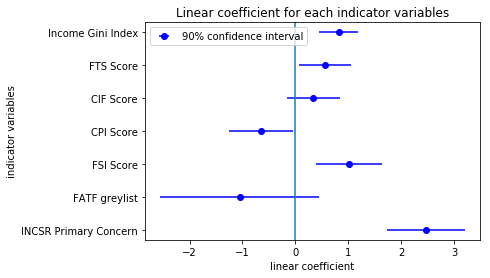

In [112]:
#Plot with confidence intervals for visual interpretation
plt.errorbar(result['Linear coefficient'], result.index,xerr=CI,fmt='bo', label='90% confidence interval')
plt.axvline(x=0)
plt.title('Linear coefficient for each indicator variables')
plt.xlabel('linear coefficient')
plt.ylabel('indicator variables')
plt.legend(loc='upper left')

# Description of results

## Financial indicators
One of the best predictors for the links between a country and Mossack Fonseca is the Financial Secrecy Index (FSI). From the observations above, an increase of 1% of a country in the FSI should results in an increase of roughly 1% in its number of apparition in the Panama Papers. In short, the Secrecy Index is actually an accurate predictor of financial secrecy.

There also seems to be an undeniable relationship between Income Inequality (Gini Index) and the number of dealings with Mossack Fonseca, though it remains unclear whether this relationship is causal or not. One explication would be that higher inequality leads to higher number of high-income clients looking to avoid the equally high taxes by transferring their money to a tax haven.

On the other hand, the Financial Transparency and Standards index seems to be of little reliability when trying to predict the dealings of a country with Mossack Fonseca.

## Mossack Fonseca might be involved in actual money laundering

Mossack Fonseca is not only suspected of helping tax evasion schemes, but there is also concern that the firm might be involved in money laundering activities. In order to dig into this problem, we have decided to take a look at the Financial Action Task Force (FATF) greylist of countries with low anti-money laundering (AML) regulations and practices. The results show that Mossack Fonseca avoids to deal with such countries.

On the other hand, the firm is working with a lot of clients from the countries listed in the US State Department's "Primary concern" for money laundering (ML), which are countries currently suspected of taking part in ML activities.

## Financial crime indicators prove to be ineffective
The commonly referred to corruption (Corruption Perception Index, CPI) and illicit financial flow (Cumulative Illicit Flows, CIF) scores used by some regulators have little implication on whether the countries appear in the Panama Papers. 